In [244]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
import sys
!{sys.executable} -m pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [113]:
# Downloads 1 year worth of price data
def download(symbol, start=None):
    delta = datetime.timedelta(days=365)
    if not start:
        start = datetime.datetime(2000,1,1)

    return yf.download(symbol, start=start, end=start+delta)['Adj Close']


In [115]:
download('AAPL', datetime.datetime(2020,1,1))

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02     72.960449
2020-01-03     72.251144
2020-01-06     72.826866
2020-01-07     72.484337
2020-01-08     73.650345
                 ...    
2020-12-23    128.349167
2020-12-24    129.339050
2020-12-28    133.964966
2020-12-29    132.181213
2020-12-30    131.054153
Name: Adj Close, Length: 252, dtype: float64

Get the list of current S&P 500 companies

In [7]:
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers.head())


  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                   Biotechnology   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


Download the historical price data (Adj Close) and construct the design matrix

In [148]:
def construct_data(start, filename):
    df_spx = pd.DataFrame()
    for item in tickers['Symbol']:
        stock = download(item, start)
        df_spx = pd.concat((df_spx, stock.rename(item)), axis=1)
    df_spx.to_csv(filename)
    return df_spx


In [149]:
filename = 'spx_adj_close.csv'
try:
    df_spx = pd.read_csv(filename, index_col=0)
except FileNotFoundError:
    df_spx = construct_data(datetime.datetime(2020,1,1), filename)

In [119]:

# Clean the data
df_spx = df_spx.reset_index(drop=True)
df_spx.fillna(0, inplace=True)
df_spx = df_spx.loc[(df_spx!=0).any(axis=1)]
df_spx = df_spx.loc[:, (df_spx != 0).all(axis=0)]
df_spx


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,119.836891,44.004040,80.490295,73.511124,196.918167,334.429993,49.099998,17.447662,47.664455,83.502014,...,24.862421,18.037565,192.425278,140.598831,55.022358,75.651695,94.008141,259.140015,140.247604,129.823135
1,118.804970,43.617149,79.509056,72.813332,196.590240,331.809998,48.599998,17.247314,47.333881,82.161331,...,24.904722,18.114357,192.472382,138.513367,55.286968,76.097008,93.713707,256.049988,139.880997,129.842484
2,118.918144,43.893501,79.925598,73.387993,195.306503,333.709991,48.389999,17.447662,47.199867,82.404213,...,24.853968,18.352400,192.707870,138.239227,55.207581,75.604332,93.658493,258.010010,139.072586,128.845657
3,118.438812,43.598724,79.481277,72.969315,191.089844,333.390015,48.250000,17.508640,46.753155,82.656815,...,24.693233,18.352400,192.312241,138.895203,55.092915,75.320099,93.824097,256.470001,138.950394,129.281143
4,120.256287,43.534241,79.805260,73.486481,191.464661,337.869995,47.830002,17.473797,46.896103,83.472878,...,24.786293,18.068285,192.528885,139.766602,55.039989,75.575897,93.989738,247.639999,140.614197,129.000534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,121.017647,51.819920,101.035461,89.475456,245.103210,496.910004,91.550003,21.164495,39.971607,114.695503,...,28.947794,17.305185,198.851501,113.837593,58.215801,95.736229,100.149780,379.739990,140.929733,155.592056
248,121.386284,52.167824,101.881737,89.458138,244.969910,499.859985,91.809998,20.966276,40.256268,114.705254,...,29.154501,17.296844,201.698761,112.939140,58.505466,96.235397,100.853149,376.890015,141.412949,156.438843
249,121.518433,52.299465,101.355179,89.622749,247.235840,498.950012,91.599998,20.993307,40.329720,115.213730,...,29.033928,16.796453,198.013458,114.005440,59.130093,96.350586,102.953865,382.589996,141.071854,158.064346
250,120.920265,51.443798,101.862930,90.705673,245.407883,502.109985,90.620003,21.002317,40.173622,114.627052,...,28.706636,16.746412,197.870636,112.860146,59.220608,95.525040,102.644363,378.040009,144.444901,158.774948


Calculate for the returns matrix R

In [120]:

R = df_spx.pct_change().fillna(0)
R.head()


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.008611,-0.008792,-0.012191,-0.009492,-0.001665,-0.007834,-0.010183,-0.011483,-0.006935,-0.016056,...,0.001701,0.004257,0.000245,-0.014833,0.004809,0.005886,-0.003132,-0.011924,-0.002614,0.000149
2,0.000953,0.006336,0.005239,0.007892,-0.006530,0.005726,-0.004321,0.011616,-0.002831,0.002956,...,-0.002038,0.013141,0.001223,-0.001979,-0.001436,-0.006474,-0.000589,0.007655,-0.005779,-0.007677
3,-0.004031,-0.006716,-0.005559,-0.005705,-0.021590,-0.000959,-0.002893,0.003495,-0.009464,0.003065,...,-0.006467,0.000000,-0.002053,0.004745,-0.002077,-0.003759,0.001768,-0.005969,-0.000879,0.003380
4,0.015345,-0.001479,0.004076,0.007087,0.001961,0.013438,-0.008705,-0.001990,0.003058,0.009873,...,0.003769,-0.015481,0.001127,0.006274,-0.000961,0.003396,0.001765,-0.034429,0.011974,-0.002171


Calculate standardized returns Y

In [131]:
Y = ((R - R.mean(axis=0))/R.std(axis=0)).fillna(0)
Y.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,-0.013517,-0.037839,-0.050216,-0.049953,-0.046086,-0.067169,-0.084386,-0.036231,-0.000175,-0.066267,...,-0.035951,-0.012484,-0.016320,-0.010408,-0.024792,-0.048077,-0.026058,-0.065528,-0.019108,-0.045931
1,-0.379139,-0.404553,-0.542751,-0.481809,-0.109370,-0.326307,-0.350051,-0.349852,-0.189594,-0.762148,...,0.002977,0.092830,-0.006780,-0.283916,0.170807,0.154474,-0.138560,-0.446829,-0.101921,-0.039880
2,0.026931,0.226425,0.161449,0.309107,-0.294235,0.122239,-0.197113,0.281033,-0.077502,0.061858,...,-0.082579,0.312591,0.031361,-0.046902,-0.083195,-0.270860,-0.047222,0.179252,-0.202199,-0.357673
3,-0.184662,-0.317947,-0.274819,-0.309503,-0.866533,-0.098886,-0.159863,0.059222,-0.258660,0.066593,...,-0.183918,-0.012484,-0.096327,0.077092,-0.109269,-0.177442,0.037454,-0.256394,-0.046943,0.091314
4,0.638039,-0.099528,0.114473,0.272492,0.028452,0.377318,-0.311475,-0.090584,0.083330,0.361642,...,0.050274,-0.395445,0.027582,0.105278,-0.063865,0.068785,0.037357,-1.166470,0.360237,-0.134068


Construct the correlation matrix

In [153]:
def consrtuct_correlation_matrix(Y, filename):
    p = pd.DataFrame(columns=Y.columns, index=Y.columns)
    for i in Y.columns:
        for j in Y.columns:
            # print(Y[i].sum())
            p[i][j] = ((Y[i] * Y[j]).sum())
    p.head(100)
    p.to_csv(filename)
    return p


In [152]:
filename_corr = 'correlation_matrix.csv'
try:
    p = pd.read_csv(filename_corr, index_col=0)
except FileNotFoundError:
    p = consrtuct_correlation_matrix(Y, filename_corr)
p.dropna(inplace=True)
p.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,251.000000,168.405950,153.627747,132.005021,167.292474,104.326440,95.655049,133.501426,146.511284,153.779918,...,179.787561,126.304981,137.096244,116.965458,143.206040,188.227017,157.730064,166.840029,149.357560,143.250397
AOS,168.405950,251.000000,114.580098,96.114010,129.642929,103.065615,84.488275,118.137406,125.432216,136.082705,...,150.369007,96.416307,103.766175,114.658813,119.372912,161.163225,115.325623,151.510823,103.507352,111.448989
ABT,153.627747,114.580098,251.000000,156.482001,167.596654,143.794851,126.516787,82.923617,109.394385,180.137425,...,148.959895,81.577946,144.514425,59.093258,170.151931,149.926382,124.748170,147.794553,106.669606,178.442249
ABBV,132.005021,96.114010,156.482001,251.000000,156.122847,135.823359,110.163324,107.261538,122.391355,154.869301,...,128.724817,128.046790,125.793400,93.277452,124.645807,127.942400,118.594183,131.736183,119.785068,163.097729
ACN,167.292474,129.642929,167.596654,156.122847,251.000000,176.037086,130.380936,159.619791,143.924798,181.587033,...,177.438693,138.636619,168.983700,121.550053,153.409430,173.686207,162.067628,177.356673,160.638599,178.245795


Calculate the Principal Components of the correlation matrix

In [136]:
def pca(X):
    l, w_prime = np.linalg.eigh(X)
    sorted_indices = np.argsort(l)[::-1]
    l = l[sorted_indices]
    w_prime = w_prime[:, sorted_indices]
    X_rotated = np.dot(X, w_prime)
    variance_explained = l / np.sum(l)
    return X_rotated, w_prime, variance_explained, l


In [137]:
X_rotated, w_prime, variance_explained, l = pca(p)

Plot of the eigenvalues vs explained variance

Text(0, 0.5, 'variance explained')

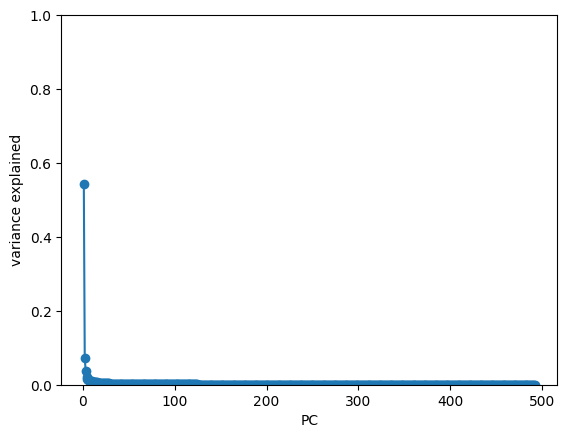

In [138]:
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('variance explained')

Plot the Density of States

Text(0.5, 0, 'Density Of States')

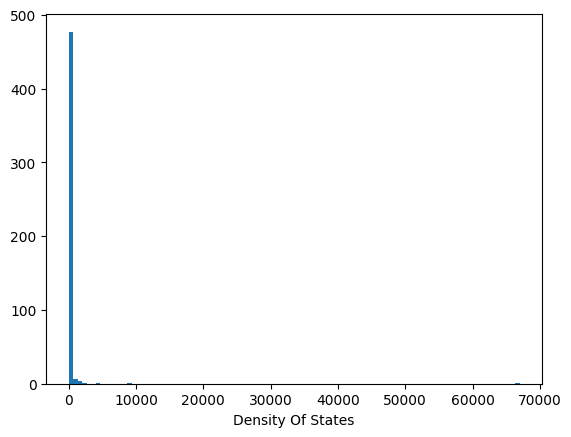

In [139]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

Calculate the Eigenportfolio Returns

In [140]:
F = pd.DataFrame(w_prime)
F = F.divide(R.std(axis=0).to_numpy(), axis = 1)
print(F)
print(R)

F = F @ R.T.to_numpy()
F = F.T
# print(F)


          0         1         2         3         4         5         6    \
0    2.060446  0.044844 -1.486513  2.130862 -2.991195  1.296995 -1.835388   
1    1.711701  0.119398 -0.737018  2.440668 -2.063816 -1.960856 -2.924870   
2    1.798512 -3.323833 -0.623607  0.874289 -2.167551  1.327458  1.575161   
3    1.754338 -1.277885  0.528964  0.718460  0.902977  2.096353  2.629842   
4    2.217961 -0.949410  1.090322  1.177218  0.577905  0.236948  0.919204   
..        ...       ...       ...       ...       ...       ...       ...   
487  2.208262 -0.077066 -1.866680  0.600992 -0.204410  0.414881 -1.776315   
488  1.975725  0.828674  1.081082 -3.013860 -4.395618  0.928154  0.404701   
489  2.026909 -0.845528  0.466246  3.506253 -0.824833 -1.866797 -0.392184   
490  1.889300  2.020039  1.290899 -0.511729 -1.762355  1.489673  2.517179   
491  2.027235 -1.995224  1.129534 -1.797873 -2.168284  0.976233  1.587994   

          7         8         9    ...       482       483       484  \
0  

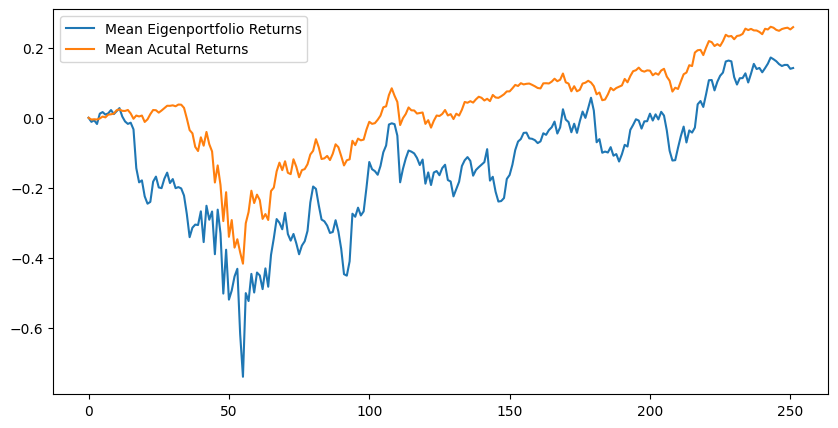

In [141]:
FM = F.mean(axis=1)
RM = R.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(FM.cumsum(),  label="Mean Eigenportfolio Returns")
ax.plot(RM.cumsum(), label = "Mean Acutal Returns")
plt.legend()

Plot the first Eigenvector

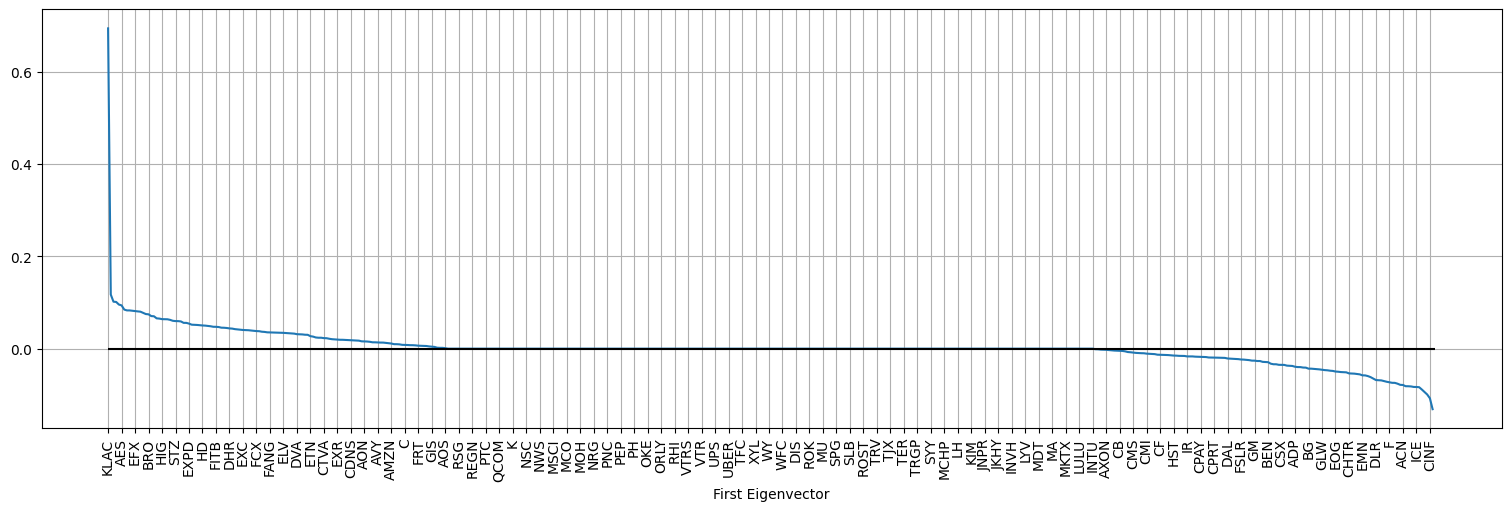

In [142]:
import matplotlib.ticker as tck
E = pd.DataFrame(w_prime)
E.columns = R.columns
E = E.sort_values(0,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[0])
ax.set_xlabel('First Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

Top and Bottom 10 Stocks for Egienvector 1

In [143]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)


Top 10 Stocks
    Symbol                    Security             GICS Sector
7      AES             AES Corporation               Utilities
43     ADM      Archer-Daniels-Midland        Consumer Staples
75    AVGO               Broadcom Inc.  Information Technology
84     CPB       Campbell Soup Company        Consumer Staples
101    CRL  Charles River Laboratories             Health Care
147   DXCM                      Dexcom             Health Care
156    DOW                    Dow Inc.               Materials
174   EPAM                EPAM Systems  Information Technology
190   FFIV                    F5, Inc.  Information Technology
280   KLAC             KLA Corporation  Information Technology

Bottom 10 Stocks
    Symbol                   Security  GICS Sector
52     AVB      AvalonBay Communities  Real Estate
68      BX                 Blackstone   Financials
86     CAH            Cardinal Health  Health Care
92    CBOE        Cboe Global Markets   Financials
109   CINF       Cin

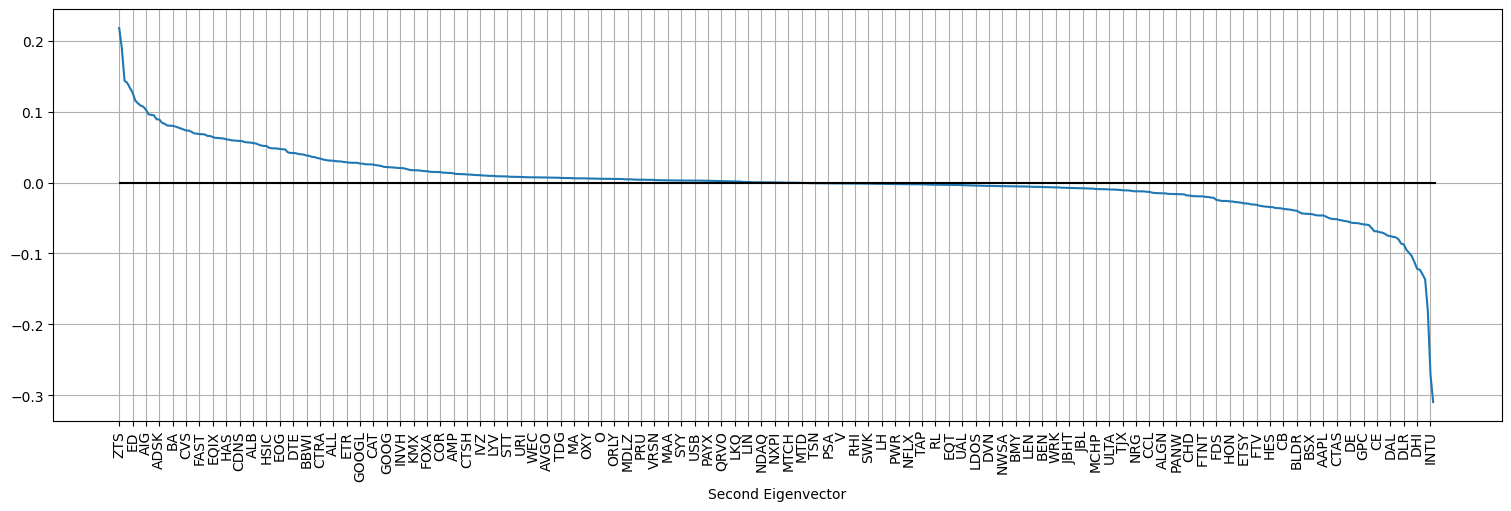

In [144]:
E = E.sort_values(1,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[1])
ax.set_xlabel('Second Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

Top and Bottom 10 Stocks for Egienvector 2

In [145]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)


Top 10 Stocks
    Symbol                  Security  GICS Sector
23    AMCR                     Amcor    Materials
38     APA           APA Corporation       Energy
48     ATO              Atmos Energy    Utilities
113    CFG  Citizens Financial Group   Financials
115    CME                 CME Group   Financials
124     ED       Consolidated Edison    Utilities
139    DHR       Danaher Corporation  Health Care
159    DUK               Duke Energy    Utilities
360   PCAR                    Paccar  Industrials
502    ZTS                    Zoetis  Health Care

Bottom 10 Stocks
    Symbol                 Security             GICS Sector
6      AMD   Advanced Micro Devices  Information Technology
44    ANET          Arista Networks  Information Technology
58      BK  Bank of New York Mellon              Financials
60     BAX     Baxter International             Health Care
111   CSCO                    Cisco  Information Technology
112      C                Citigroup              Financial

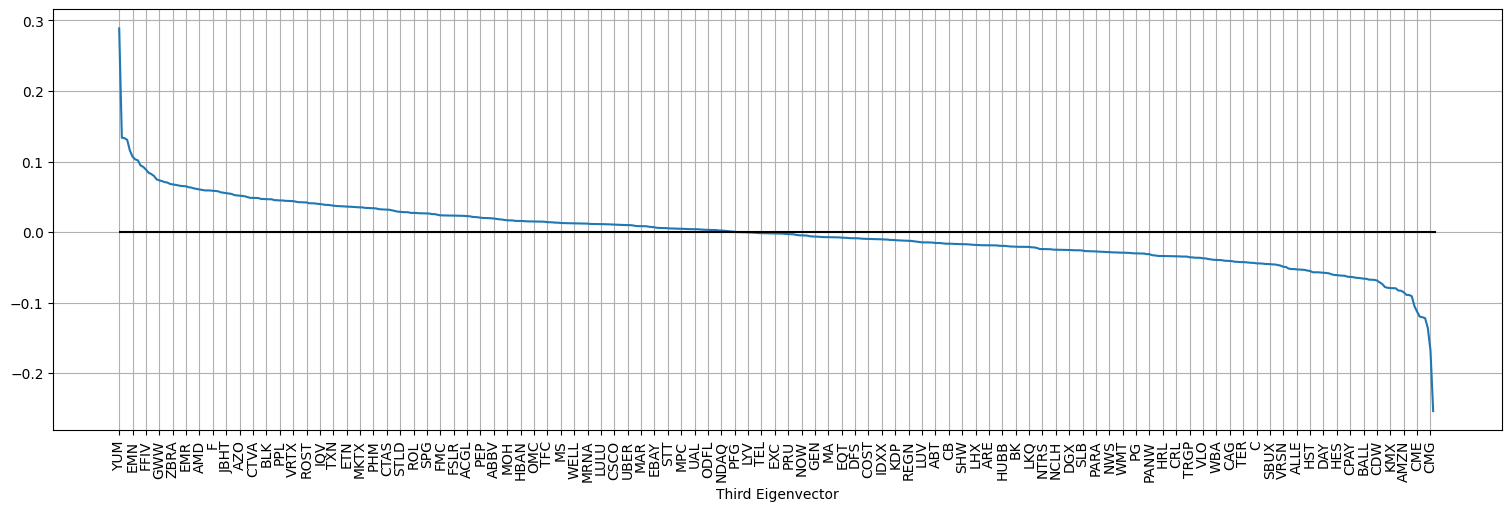

In [146]:
E = E.sort_values(2,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[2])
ax.set_xlabel('Third Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

Top and Bottom 10 Stocks for Egienvector 3

In [147]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)


Top 10 Stocks
    Symbol                  Security             GICS Sector
161    EMN  Eastman Chemical Company               Materials
173    EOG             EOG Resources                  Energy
188    EXR       Extra Space Storage             Real Estate
209   GRMN                    Garmin  Consumer Discretionary
219    GPC     Genuine Parts Company  Consumer Discretionary
229   HSIC              Henry Schein             Health Care
236    HON                 Honeywell             Industrials
251     IR            Ingersoll Rand             Industrials
499    YUM               Yum! Brands  Consumer Discretionary
502    ZTS                    Zoetis             Health Care

Bottom 10 Stocks
    Symbol                Security             GICS Sector
85     COF             Capital One              Financials
105    CMG  Chipotle Mexican Grill  Consumer Discretionary
115    CME               CME Group              Financials
146    DVN            Devon Energy                  Energy
14

Repeat the PCA on data right after the data we used

In [198]:
filename2 = 'spx2_adj_close.csv'
try:
    df_spx = pd.read_csv(filename2, index_col=0)
except FileNotFoundError:
    df_spx = construct_data(datetime.datetime(2022,1,1), filename2)

In [188]:
# Clean the data
df_spx = df_spx.reset_index(drop=True)
df_spx.fillna(0, inplace=True)
df_spx = df_spx.loc[(df_spx!=0).any(axis=1)]
df_spx = df_spx.loc[:, (df_spx != 0).all(axis=0)]

Calculate Standardized Returns

In [189]:

R = df_spx.pct_change().fillna(0)
# R.head()

In [190]:
Y = ((R - R.mean(axis=0))/R.std(axis=0)).fillna(0)
Y.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
0,0.071130,0.063080,0.043714,-0.067846,0.067751,0.058094,0.068014,-0.045734,-0.070874,-0.004202,...,0.033882,-0.067657,-0.021136,-0.011372,-0.023480,-0.003358,0.004226,0.097273,-0.014779,0.081410
1,0.887249,0.908945,-1.357481,-0.203988,-0.275144,-0.589228,-0.941245,0.084059,2.137607,-1.524034,...,0.690394,0.432166,0.818993,-0.098410,0.415672,0.476819,0.357008,0.314145,0.513441,-1.817425
2,-0.168054,-0.786896,-0.223987,0.304673,-0.777259,-2.458205,-1.423898,-2.116323,-0.182828,-0.774374,...,-1.237598,0.056174,-0.465167,-1.021674,0.656471,-0.620266,-0.832172,-1.616314,-0.186427,-1.815036
3,-0.412476,0.403976,0.034901,-0.401895,-2.249358,0.036865,0.083323,-0.220106,1.173909,0.153132,...,0.442930,1.250284,-0.740331,0.114918,-0.566189,-0.065510,0.685824,-0.087901,-0.447310,0.279472
4,0.709332,-0.511381,0.228879,-0.251396,-0.852543,-0.176256,-0.740955,-0.318036,0.997191,-1.201117,...,-0.029529,1.078752,-0.778497,-0.040382,0.584281,-0.365134,-0.752325,-1.400802,-0.329783,-1.370649


Construct The Correlation Matrix

In [199]:
filename_corr2 = 'correlation_matrix2.csv'
try:
    p = pd.read_csv(filename_corr2, index_col=0)
except FileNotFoundError:
    p = consrtuct_correlation_matrix(Y, filename_corr2)
p.dropna(inplace=True)
p.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,251.000000,96.669160,17.296143,33.971574,84.220279,-11.987782,-27.501616,2.324920,109.565011,20.206028,...,74.875156,70.131403,53.983579,19.093083,62.341512,97.044192,63.029724,33.789031,51.481262,18.269760
AOS,96.669160,251.000000,36.202559,69.743497,109.972506,33.011655,20.791934,86.358705,129.481349,80.373881,...,114.496664,80.310696,75.199925,56.263741,44.302108,144.193064,74.421241,92.017818,70.126879,66.030112
ABT,17.296143,36.202559,251.000000,60.286216,84.174763,89.809534,38.798321,52.901234,7.539149,111.382460,...,16.517163,-14.168134,43.130480,-22.200184,49.809286,43.346869,25.822236,49.570969,39.839418,107.167467
ABBV,33.971574,69.743497,60.286216,251.000000,71.016956,36.467987,7.916760,60.509496,60.798698,57.473030,...,48.818837,48.368538,25.591403,9.874846,46.839193,32.131629,49.850664,38.382306,62.920914,81.711635
ACN,84.220279,109.972506,84.174763,71.016956,251.000000,104.399232,63.410597,84.478582,100.505606,119.564695,...,100.156172,60.416087,89.818787,27.772707,60.377056,127.668538,94.020746,121.332393,82.993932,138.247590


Perform PCA

In [200]:
X_rotated, w_prime, variance_explained, l = pca(p)

Plot Principal Components vs explained variance

Text(0, 0.5, 'variance explained')

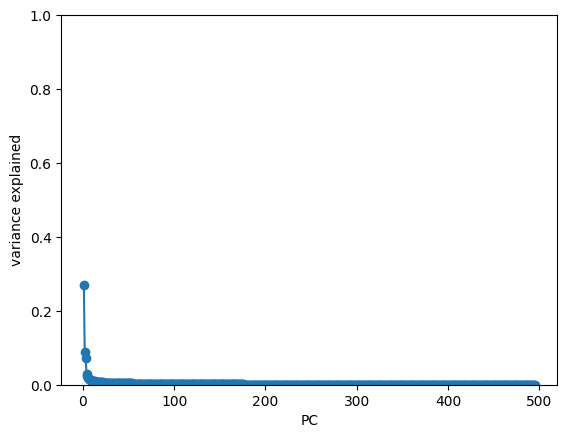

In [201]:
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-')
plt.ylim(0,1)
plt.xlabel('PC')
plt.ylabel('variance explained')

Plot the Density of States

Text(0.5, 0, 'Density Of States')

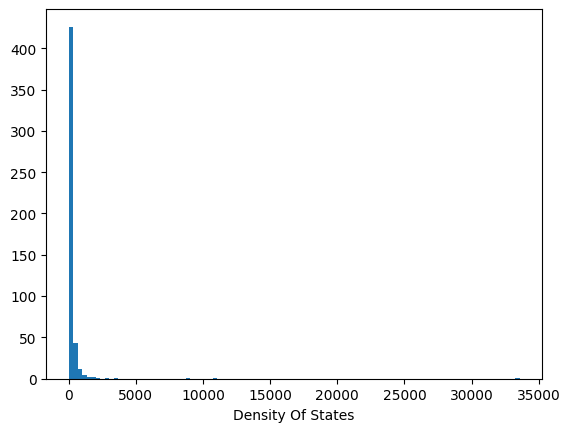

In [202]:
plt.hist(l, bins=100)
plt.xlabel('Density Of States')

Calculate the Eigenportfolio Returns

In [205]:
F = pd.DataFrame(w_prime)
F = F.divide(R.std(axis=0).to_numpy(), axis = 1)
print(F)
print(R)

F = F @ R.T.to_numpy()
F = F.T

          0         1         2         3         4         5         6    \
0    2.272012  0.500958 -4.150850  2.930861 -4.927661 -2.304695  1.649938   
1    3.277432  0.022059 -0.815230  4.975162  1.485003 -1.931027 -0.441493   
2    0.996117 -3.859777 -0.062751  2.487056  0.886929  1.803218 -1.138147   
3    1.791459 -1.087547 -1.269759  1.056333  0.524122  4.108006  0.863594   
4    3.200480 -2.849926 -0.037711  1.491499  0.210052  0.569610  1.625699   
..        ...       ...       ...       ...       ...       ...       ...   
490  3.635233 -0.433046  0.799361  4.726859  1.232768 -2.606037  0.512811   
491  2.687134 -1.194617 -1.086233 -2.026180  1.400624 -0.899823  1.470828   
492  2.719528 -1.927853  3.595082  1.494142 -1.039189 -1.023806 -0.995840   
493  2.768723 -0.128928 -0.249381 -5.454461  2.162810  0.918150  0.433430   
494  1.990635 -4.531485  0.845079  1.201859  2.012546  1.229408  1.047437   

          7         8         9    ...       485       486       487  \
0  

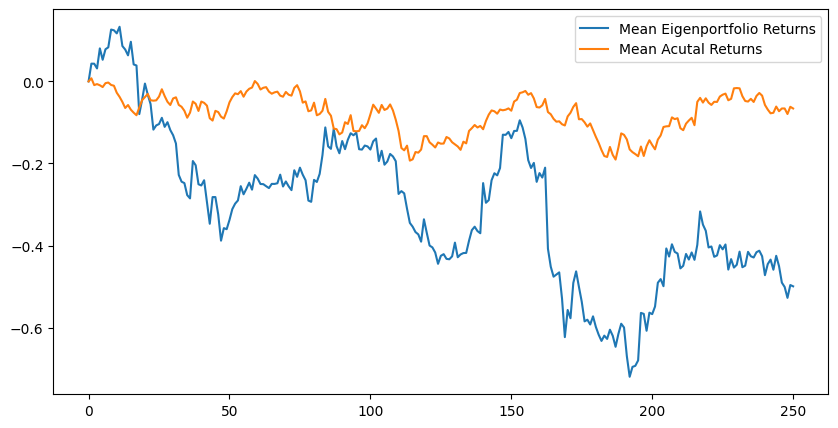

In [206]:
FM = F.mean(axis=1)
RM = R.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(FM.cumsum(),  label="Mean Eigenportfolio Returns")
ax.plot(RM.cumsum(), label = "Mean Acutal Returns")
plt.legend()

Plot The First Eigenvector

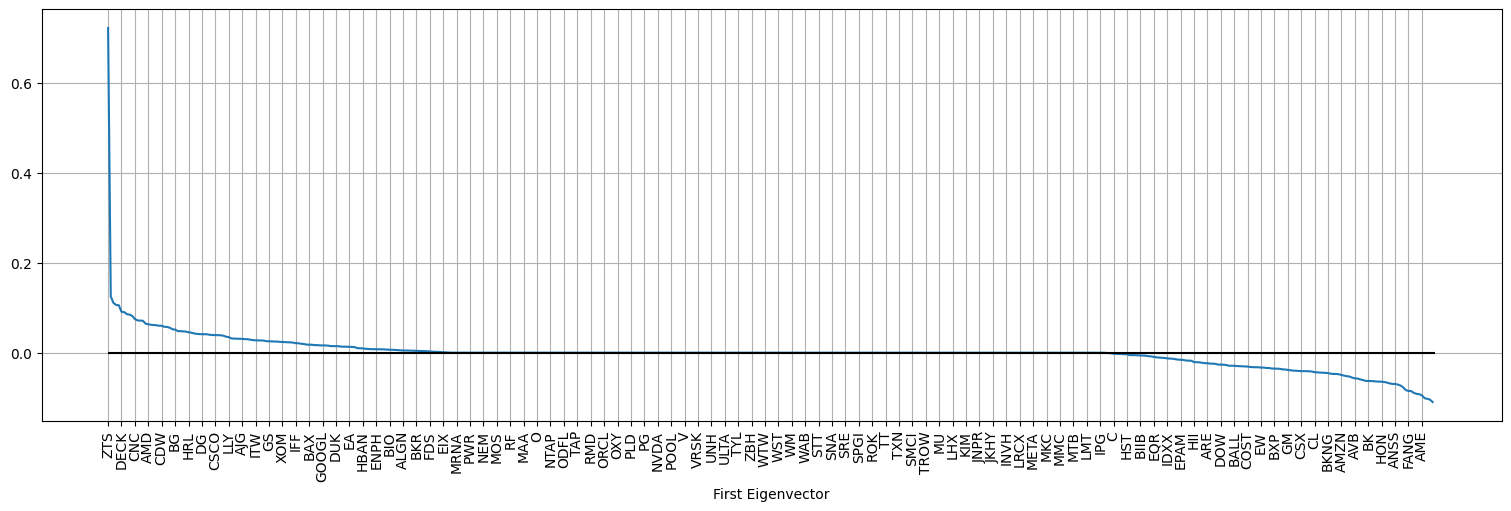

In [186]:
import matplotlib.ticker as tck
E = pd.DataFrame(w_prime)
E.columns = R.columns
E = E.sort_values(0,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[0])
ax.set_xlabel('First Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

In [171]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)

Top 10 Stocks
    Symbol                  Security             GICS Sector
12    AKAM                    Akamai  Information Technology
30     AWK      American Water Works               Utilities
47       T                      AT&T  Communication Services
69      BA                    Boeing             Industrials
137    CMI                   Cummins             Industrials
143   DECK            Deckers Brands  Consumer Discretionary
187   EXPD  Expeditors International             Industrials
199     FE               FirstEnergy               Utilities
249   ILMN                  Illumina             Health Care
502    ZTS                    Zoetis             Health Care

Bottom 10 Stocks
    Symbol            Security             GICS Sector
4      ACN           Accenture  Information Technology
32     AME              Ametek             Industrials
77     BRO       Brown & Brown              Financials
148   FANG  Diamondback Energy                  Energy
154    DPZ            

Plot the Second Eigenvector

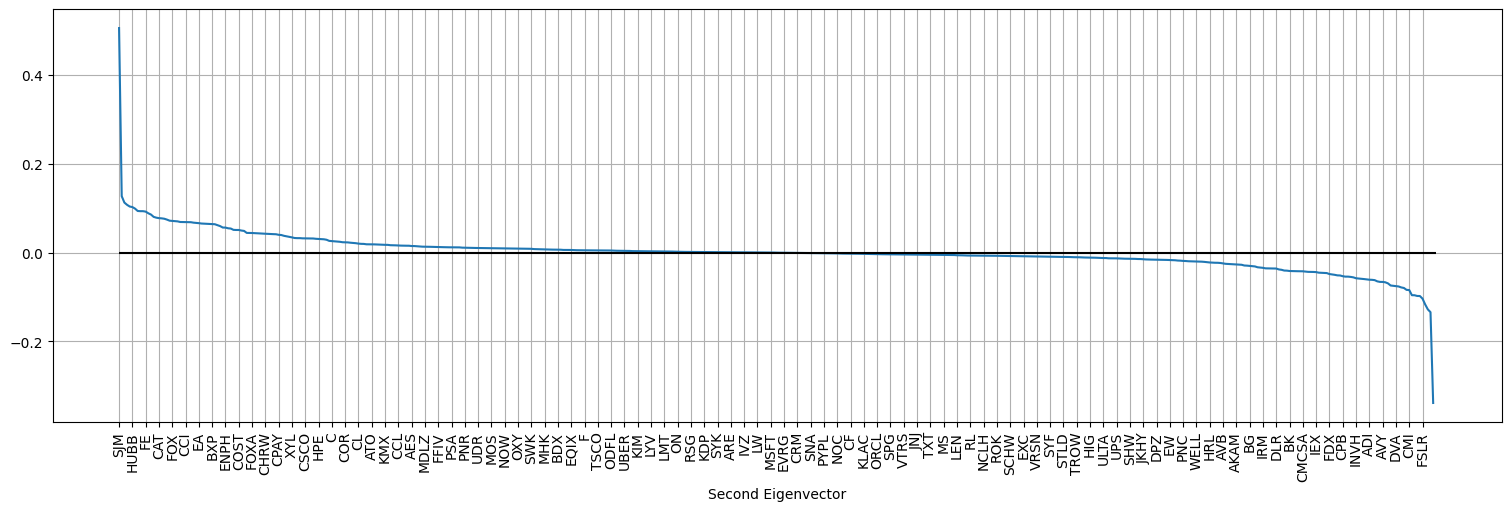

In [172]:
E = E.sort_values(1,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[1])
ax.set_xlabel('Second Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

In [173]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)

Top 10 Stocks
    Symbol                    Security             GICS Sector
29     AMT              American Tower             Real Estate
63     BBY                    Best Buy  Consumer Discretionary
106     CB               Chubb Limited              Financials
189    XOM                  ExxonMobil                  Energy
240    HPQ                     HP Inc.  Information Technology
241   HUBB        Hubbell Incorporated             Industrials
252   PODD                     Insulet             Health Care
418    SJM  J.M. Smucker Company (The)        Consumer Staples
438    TGT          Target Corporation        Consumer Staples
494    WMB          Williams Companies                  Energy

Bottom 10 Stocks
    Symbol                      Security             GICS Sector
28     AIG  American International Group              Financials
56    BALL              Ball Corporation               Materials
71     BWA                    BorgWarner  Consumer Discretionary
109   CINF     

Plot the Third Eigenvector

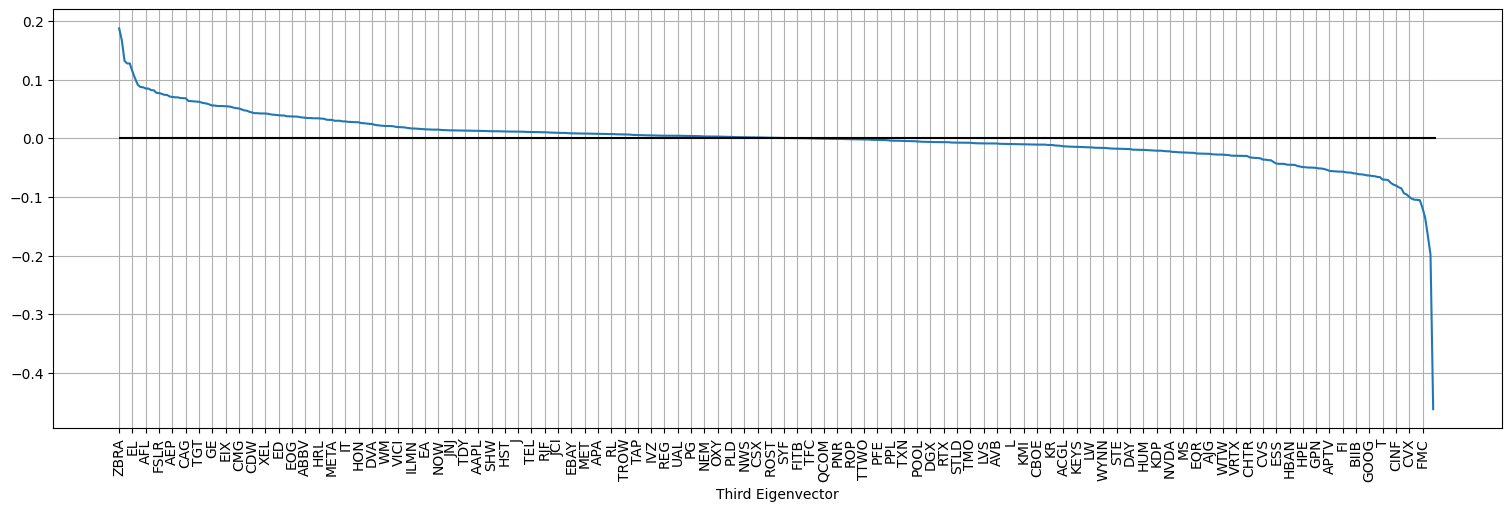

In [174]:
E = E.sort_values(2,axis=1, ascending=False)
fig, ax = plt.subplots(1,1, figsize=(15,5), layout='constrained')
ax.grid(visible=True,which='major')
major_ticks_x = [x for x in range(len(E.columns))][::5]
major_labels_x = E.columns[::5]
ax.set_xticks(major_ticks_x)
ax.set_xticklabels(major_labels_x, rotation=90)
ax.plot(E.columns,E.iloc[2])
ax.set_xlabel('Third Eigenvector')
plt.hlines(0,0,len(E.columns), colors='black')

In [175]:
print('Top 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[:10])][['Symbol','Security','GICS Sector']]
print(list10)

print('\nBottom 10 Stocks')
list10 = tickers.loc[tickers['Symbol'].isin(E.columns[-10:])][['Symbol','Security','GICS Sector']]
print(list10)

Top 10 Stocks
    Symbol                      Security             GICS Sector
27     AXP              American Express              Financials
34     APH                      Amphenol  Information Technology
48     ATO                  Atmos Energy               Utilities
95      CE                      Celanese               Materials
180     EL  Estée Lauder Companies (The)        Consumer Staples
209   GRMN                        Garmin  Consumer Discretionary
214    GEN                   Gen Digital  Information Technology
222     GL                    Globe Life              Financials
500   ZBRA            Zebra Technologies  Information Technology
501    ZBH                 Zimmer Biomet             Health Care

Bottom 10 Stocks
    Symbol                              Security             GICS Sector
25     AAL               American Airlines Group             Industrials
54    AXON                       Axon Enterprise             Industrials
104    CVX                   Chevr

Check if the Eigenportfolio returns are uncorrelated

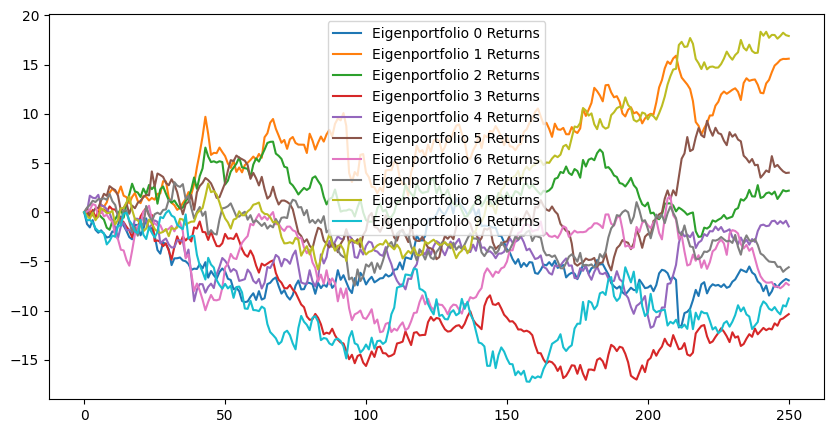

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for i in range(10):
    ax.plot(F[i].cumsum(),  label=f"Eigenportfolio {i} Returns")
plt.legend()

Check if Eigenporfolio return distributions are approximately normal

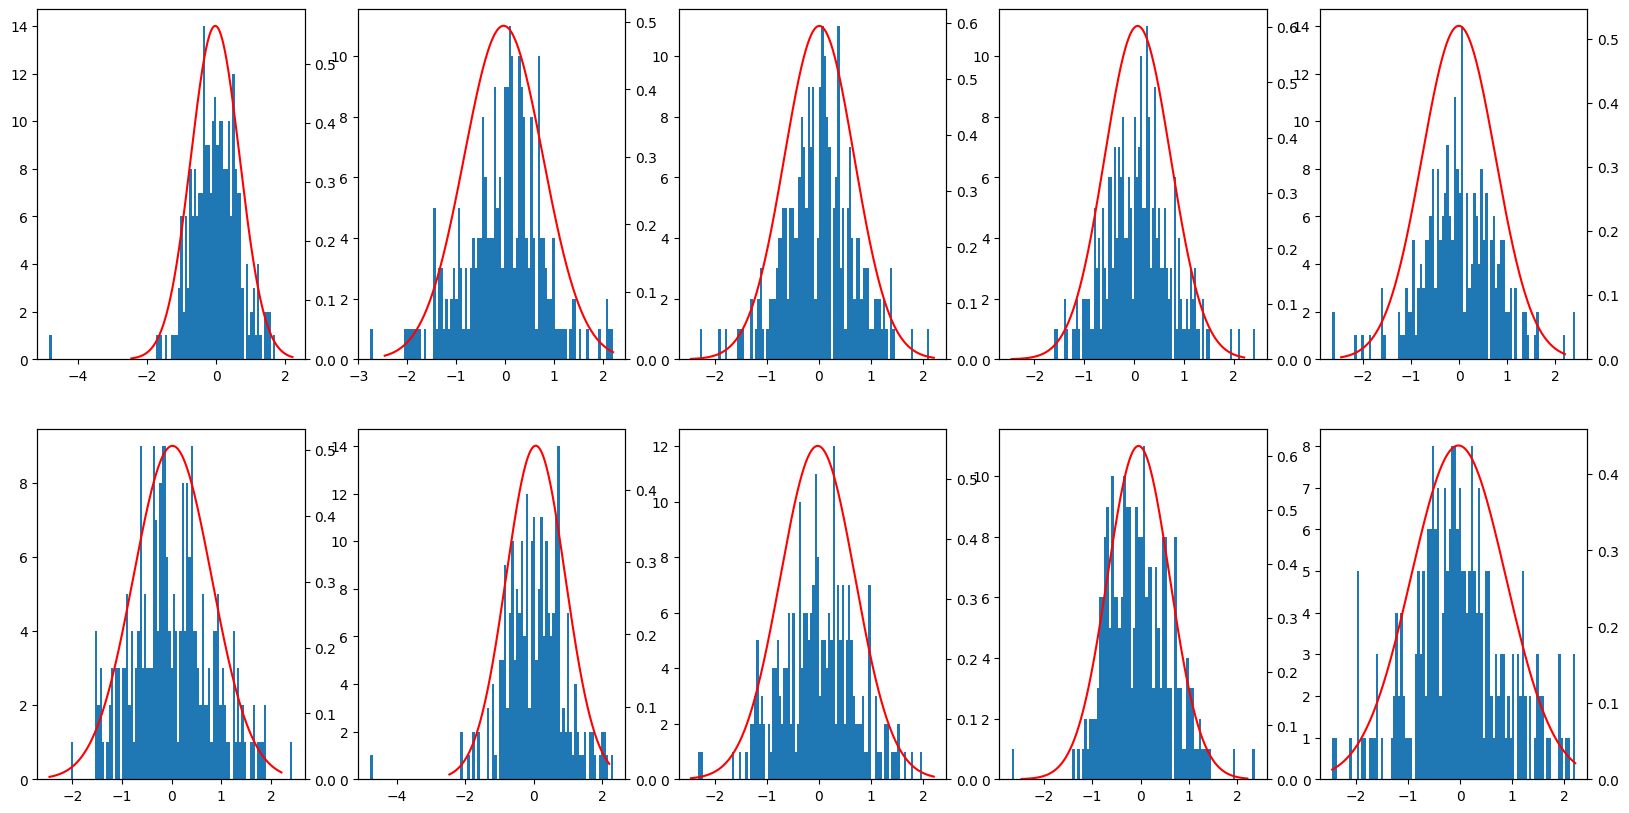

In [250]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
x =  np.linspace(F[i].min(), F[i].max(), 1000)
   
for i in range(10):
    ax[i%2][i%5].hist(F[i], bins=100)
    params = stats.norm.fit(F[i])
    pdf_fitted = stats.norm.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    tx = ax[i%2][i%5].twinx()
    tx.plot(x, pdf_fitted, label='', color = 'r')
    tx.set_ylim(0)


Null Hypothesis (H₀): The datasets are not correlated (correlation coefficient = 0).<br>
Alternative Hypothesis (H₁): The datasets are correlated (correlation coefficient ≠ 0).

In [267]:
from scipy.stats import pearsonr, spearmanr, kendalltau

alpha = 0.05
p_values = {}
for i in range(5):
    for j in range(5):
        if i == j:
            pass
        else:
            # Pearson Correlation
            print(f'\nFor Eigenportfolio {i} and {j}:')
            pearson_corr, pearson_p_value = pearsonr(F[i].to_numpy(), F[j].to_numpy())
            # # print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}")

            # # Spearman Correlation
            # spearman_corr, spearman_p_value = spearmanr(F[i].to_numpy(), F[j].to_numpy())
            # # print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}")

            # # Kendall's Tau
            # kendall_corr, kendall_p_value = kendalltau(F[i].to_numpy(), F[j].to_numpy())
            # # print(f"Kendall correlation: {kendall_corr}, p-value: {kendall_p_value}")

            # Interpretation
            if pearson_p_value > alpha:
                print("Pearson correlation: No significant correlation")
            else:
                print("Pearson correlation: Significant correlation")

            p_values[f'{i}-{j}'] = pearson_p_value 

            # if spearman_p_value > alpha:
            #     print("Spearman correlation: No significant correlation")
            # else:
            #     print("Spearman correlation: Significant correlation")

            # if kendall_p_value > alpha:
            #     print("Kendall correlation: No significant correlation")
            # else:
            #     print("Kendall correlation: Significant correlation")


For Eigenportfolio 0 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 2:
Pearson correlation: No significant correlation

For Eigenportfolio 0 and 3:
Pearson correlation: Significant correlation

For Eigenportfolio 0 and 4:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 0:
Pearson correlation: Significant correlation

For Eigenportfolio 1 and 2:
Pearson correlation: Significant correlation

For Eigenportfolio 1 and 3:
Pearson correlation: No significant correlation

For Eigenportfolio 1 and 4:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 0:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 1:
Pearson correlation: Significant correlation

For Eigenportfolio 2 and 3:
Pearson correlation: No significant correlation

For Eigenportfolio 2 and 4:
Pearson correlation: No significant correlation

For Eigenportfolio 3 and 0:
Pearson correlation: Significant correlation

For Eigenportfolio 

In [268]:
df_stat=pd.DataFrame()
df_stat['Eigenportfolio pair']=p_values.keys()
df_stat['p_value']=p_values.values()
alpha = 0.05
df_stat.sort_values(by='p_value', inplace=True) # Sort in place!
df_stat['L_thresholds'] = alpha/(df_stat.shape[0] + 1 - (np.arange(df_stat.shape[0]) + 1)) 
df_stat['reject'] = df_stat['p_value'] < df_stat['L_thresholds']
print(df_stat)

   Eigenportfolio pair       p_value  L_thresholds  reject
0                  0-1  8.505567e-07      0.002500    True
4                  1-0  8.505567e-07      0.002632    True
5                  1-2  2.806038e-04      0.002778    True
9                  2-1  2.806038e-04      0.002941    True
2                  0-3  5.440925e-04      0.003125    True
12                 3-0  5.440925e-04      0.003333    True
7                  1-4  1.665091e-02      0.003571   False
17                 4-1  1.665091e-02      0.003846   False
18                 4-2  5.325739e-02      0.004167   False
11                 2-4  5.325739e-02      0.004545   False
1                  0-2  9.472970e-02      0.005000   False
8                  2-0  9.472970e-02      0.005556   False
15                 3-4  1.535062e-01      0.006250   False
19                 4-3  1.535062e-01      0.007143   False
16                 4-0  4.530213e-01      0.008333   False
3                  0-4  4.530213e-01      0.010000   Fal

For the 1st 5 Eigenportfolio returns, 70% show no statistically significant correlation.